In [1]:
import numpy as np
from sympy.solvers import solve
from sympy import Symbol, symbols
import matplotlib.pyplot as plt

From Jessop 2018 Equation 17

$$A(r) = \frac{\mu}{4\pi} \int_{\Omega} \frac{J_c (r')}{|r-r'|} \,d\tau '$$




A is the magnetic vector potential at r

r is the position of the observation point P,

r' is the position of the integration point around the current source point M

$d\tau '$ denotes a volume element around the source M

$Curl(A)$ results in the Biot Savart Law being returned

Normal magnetic field:

$$ B_o (r) = \frac{\mu}{4\pi} \int J_s (r') \times \frac{r- r'}{|r-r'|^3}\,d\tau '$$

$J_s$ is the source current density inside the source region - NEED CLARIFICATION, 

Is this the vector from the EField?

See: Willowstick method

$J_s$ is defined as $\frac{A}{m^2}$

"The normal magnetic field at observation point r is given by the volume integral over the area around the source charge"

# Edwards 1974

Any component of the normal field due to a pair of electrodes can be obtaineed by the superposition of two solutions of the type,

$$H_t = \frac{I}{4 \pi r}$$



In [2]:
# Setup scenario:
pos_electrode = np.array([0, 0, -100])
plate_normal = np.array([])

In [3]:
def NField_x(x,y,L,I):
    """
    Gives the cross component of the normal field between two electrodes
    located at (0, L/2; z1) and at (0, -L/2; z2) where z1 and z2 are arbitrary 
    depths
    Implemented from equation 4.5 in Edwards 1974
    """
    a = (y/L + 0.5) / (np.power(x/L, 2) + (np.power(y/L + 0.5, 2))) 
    b = (y/L - 0.5) / (np.power(x/L, 2) + (np.power(y/L - 0.5, 2)))
    return I * (a - b) / 4 / np.pi / L

In [4]:
def NField_x_single(x,y,L,I):
    a = (y/L + 0.5) / (np.power(x/L, 2) + (np.power(y/L + 0.5, 2)))
    return I * a / 4 / np.pi / L

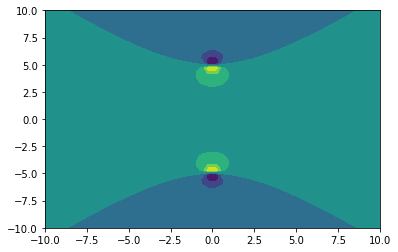

In [5]:
plt.contourf(xx, 
             yy, 
             NField_x(xx,yy,10,1))

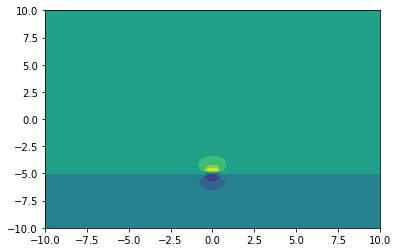

In [6]:
plt.contourf(xx, 
             yy, 
             NField_x_single(xx,yy,10,1))

# Veitch 1990
## Distributed B-Field in a Layered Earth
#### Similar to Edwards and Nabighian 1991

#### Layer coefficients are needed within the potential field integral

from Veitch 1990:
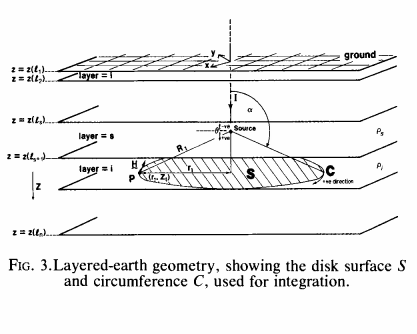

Electric potential (Voltage)
$$ U(r,z) = \frac{I \rho_s}{4\pi} \left\{ \frac{1}{R} + \int_{0}^{\infty} \left[\alpha_i(\lambda) e^{\lambda z} + \beta_i(\lambda) e^{\lambda z}\right] J_1(\lambda r)  d\lambda \right\}  $$ 

For $z \geq 0$: below the electrode, no wire through the surface of integration

$$ H(r,z) = \frac{I}{4\pi r} \left\{ r \frac{\rho_s}{\rho_p} \int_{0}^{\infty} \left[(\beta_i + 1) e^{-\lambda z} - \alpha_i e^{\lambda z}\right] J_1(\lambda r)  d\lambda - 1 + \frac{z}{R} \right\}  $$ 

For $z < 0$: above the source, wire passes through the surface of integration and flux from wire must be added

$$ H(r,z) = \frac{I}{4\pi r} \left\{ r \frac{\rho_s}{\rho_p} \int_{0}^{\infty} \left[\beta_i e^{-\lambda z} - (\alpha_i + 1) e^{\lambda z}\right] J_1(\lambda r)  d\lambda + 1 + \frac{z}{R} \right\} $$

Where $R = \sqrt{(r^2 + z^2)}$

# Calculating layer coefficients
## Notation:

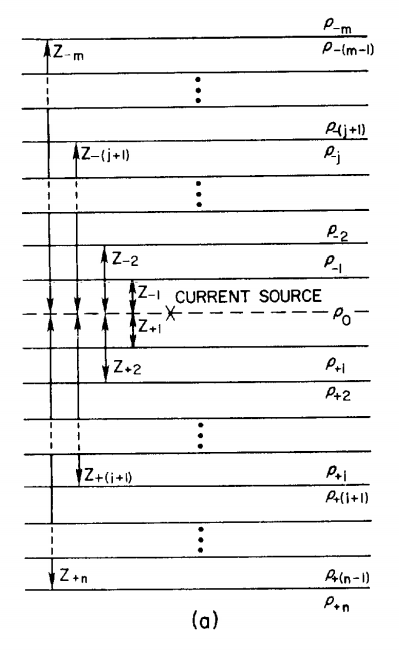

$m$ = number of layers <b>above</b> the current source

$j$ = evaluation above the current source

$n$ = number of layers <b>below</b> the current source 

$i$ = evaluation below the current source

#### Veitch 1978 Numerical Method
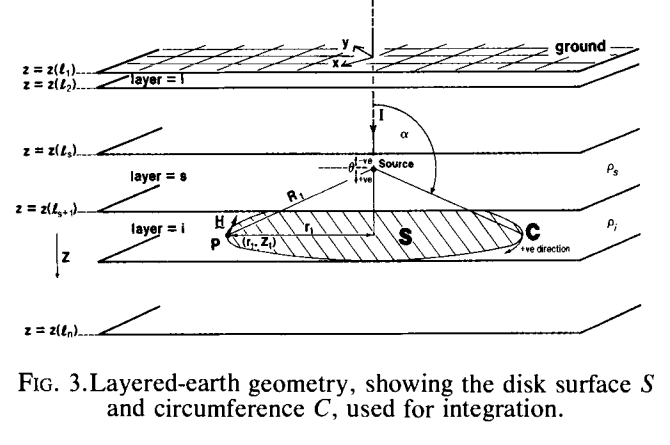

Investigation above or at source

$$\alpha_{i-1} = P^+_i \alpha_i + \frac{P^-_i(\beta_i + 1)}{h_i}$$

$$\beta_{i-1} = P^+_i \beta_i + P^-_i(\alpha_i h_i - 1)$$

Where $P^\pm_i = \frac{\rho_i \pm \rho_{i-1}}{\rho_i}$

The evaluation of height at interface i: $h_i = e^{2\lambda z(\ell_i)}$

Investigation below source

$$\alpha_{i} = P^+_{i-1} \alpha_{i-1} + P^-_{i-1}(\frac{\beta_{i-1}}{h_i} - 1)$$

$$\beta_{i} = P^+_{i-1} \beta_{i-1} + P^-_{i-1}(\alpha_{i-1} + 1)h_i$$

Where $P^\pm_{i-1} = \frac{\rho_{i-1} \pm \rho_i}{\rho_{i-1}}$

The evaluation of height at interface i: $h_i = e^{2\lambda z(\ell_i)}$ same as above


### Boundary Conditions:
$z(\ell_n)$ function takes in an interface $\ell_n$ and returns the z distance from the source. Negative for interfaces above, positive down.

Relation at the top: $\beta_1 = (\alpha_1 + 1)e^{2\lambda z(\ell_1)}$

Relation at the bottom nth layer: $\alpha_n = 0$

In [7]:
rhos = [10, 100]
depths = [50, 500]
src = 25

def z_function(lst_depths, src_depth, target_interface):
    """
    Returns the Z depth to interface 1...n from the source electrode
    """
    
    if target_interface == 1:
        return -src_depth
    else:
        return depths[target_interface - 1] - src_depth

def h_function(target_interface, lbda, src_depth, lst_depths):
    """
    Return the height function used in Veitch 1990 recursion
    """
    return np.exp(2*lbda*z_function(lst_depths, src_depth, target_interface))

def P_function_abovesrc(lst_rho, i, symbol):
    
    if len(lst_rho) == 1:
        return 1
    elif symbol == "+":
        return (lst_rho[i-1] + lst_rho[i-2]) / lst_rho[i-1]
    else:
        return (lst_rho[i-1] - lst_rho[i-2]) / lst_rho[i-1]

def P_function_belowsrc(lst_rho, i, symbol):
    
    if len(lst_rho) == 1:
        return 0
    elif symbol == "+":
        return (lst_rho[i-2] + lst_rho[i-1]) / lst_rho[i-2]
    else:
        return (lst_rho[i-2] - lst_rho[i-1]) / lst_rho[i-2]

def z_to_i(z, list_depths):
    """
    Returns the medium index given a true depth and the 
    list of interface depths
    """
    real_depths = np.cumsum(list_depths)
    d = 1
    for depth in real_depths:
        if depth < z:
            d += 1
    return d

In [9]:
def layer_2_alpha(depth, src_depth, lst_rhos, lst_depths, lbda):
    i_point = z_to_i(depth, lst_depths)
    print(f"Interface: {i_point}")
    z_1 = z_function(lst_depths, src_depth, 1)
    a1,a2 = symbols('a1:3')
    b1,b2 = symbols('b1:3')
    if depth > src_depth:
        # Point below source
        P_p = P_function_belowsrc(lst_rhos, i_point, "+")
        P_m = P_function_belowsrc(lst_rhos, i_point, "-")
        print(f"P_p: {P_p}, P_m: {P_m}")
        eqs = [
            a2 - 0
            P_p * a1 + P_m * (b2 + 1)/h_function(i_point, lbda, src_depth, lst_depths),
            (a1 + 1) * np.exp(2 * lbda * z_1) - b1,
            P_p * b2 - P_m - b1
        ]
        output = solve(eqs)
    else:
        # Point above source or at electrode
        P_p = P_function_abovesrc(lst_rhos, i_point, "+")
        P_m = P_function_abovesrc(lst_rhos, i_point, "-")
    
    return output
print(layer_2_alpha(25, 10, rhos, depths, 10))

Interface: 1
P_p: 1.1, P_m: 0.9
{a1: -6.16433781167125e+86, b1: -0.853080568720379, b2: 0.0426540284360192}


#### Daniels 1978 Recursive method

For each lambda in the integrals, a separate $(\alpha_i, \beta_i)$ has to be calculated

To solve for $\alpha_i, \beta_i$:

For $z > 0$: Below the source
$$\alpha_i = a_i + a'_i\beta_n$$

$$\beta_i = b_i + b'_i\beta_n$$

For $z \leq 0$: above the source and including the wire:

$$\alpha_{-j} = a_{-j} + a'_{-j}\beta_m$$

$$\beta_{-j} = b_{-j} + b'_{-j}\beta_m$$

To calculate, we reference <b>Daniels 1978</b> Appendix A for the algorithm. 

Calculate $a_i, a'_i, b_i, b'_i$ by recursing downwards <b> NOT INCLUDING the current source layer </b> using the following eqns:

$$a_i = \left( \frac{\rho_{i+1} + \rho_i}{2\rho_{i+1}} \right) a_{i+1} + \left( \frac{\rho_{i+1} - \rho_i}{2\rho_{i+1}} \right) e^{-2\lambda z_{i+1}} (b_{i+1} + 1) $$

$$a'_i = \left( \frac{\rho_{i+1} + \rho_i}{2\rho_{i+1}} \right) a'_{i+1} + \left( \frac{\rho_{i+1} - \rho_i}{2\rho_{i+1}} \right) e^{-2\lambda z_{i+1}} b'_{i+1} $$

$$b_i = \left( \frac{\rho_{i+1} - \rho_i}{2\rho_{i+1}} \right) e^{2\lambda z_{i+1}} a_{i+1} + \left( \frac{\rho_{i+1} + \rho_i}{2\rho_{i+1}} \right) b_{i+1} + \left( \frac{\rho_{i} - \rho_{i+1}}{2\rho_{i+1}} \right)$$

$$b'_i = \left( \frac{\rho_{i+1} - \rho_i}{2\rho_{i+1}} \right) e^{2\lambda z_{i+1}} a^`_{i+1} + \left( \frac{\rho_{i+1} + \rho_i}{2\rho_{i+1}} \right) b'_{i+1} $$



Calculate $a_{-j}, a^`_{-j}, b_{-j}, b^`_{-j}$ by recursing upwards <b> from and INCLUDING the current source layer </b> using the following eqns:

$$a_{-j} = \frac{1}{2\rho_{-(j+1)}} \left\{ (\rho_{-(j+1)} + \rho_{-j}) a_{-(j+1)} + (\rho_{-(j+1)} - \rho_{-j}) (e^{-2\lambda z_{-(j+1)}} b_{-(j+1)} - 1  \right\}$$

$$a'_{-j} = \frac{1}{2\rho_{-(j+1)}} \left\{ (\rho_{-(j+1)} + \rho_{-j}) a'_{-(j+1)} + (\rho_{-(j+1)} - \rho_{-j}) (e^{-2\lambda z_{-(j+1)}} b'_{-(j+1)}  \right\}$$

$$b_{-j} = \frac{1}{2\rho_{-(j+1)}} \left\{ (\rho_{-(j+1)} - \rho_{-j}) e^{-2\lambda z_{-(j+1)}}(a_{-(j+1)} + 1) + (\rho_{-(j+1)} + \rho_{-j}) b_{-(j+1)}  \right\}$$

$$b'_{-j} = \frac{1}{2\rho_{-(j+1)}} \left\{ (\rho_{-(j+1)} - \rho_{-j}) a^`_{-(j+1)} + (\rho_{-(j+1)} - \rho_{-j}) (e^{-2\lambda z_{-(j+1)}} b'_{-(j+1)}  \right\}$$

## Boundary Conditions for recursion:

$\beta_{-m}$ is 0 (air)

$\alpha_n$ is 0 (bottom of model)

## Using the model from Veitch 1990 fig 4

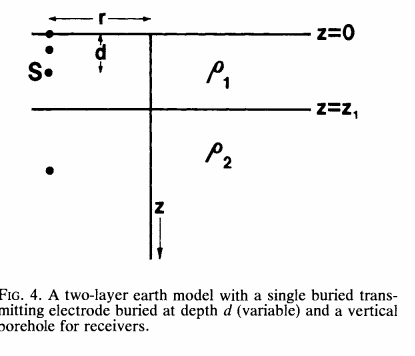

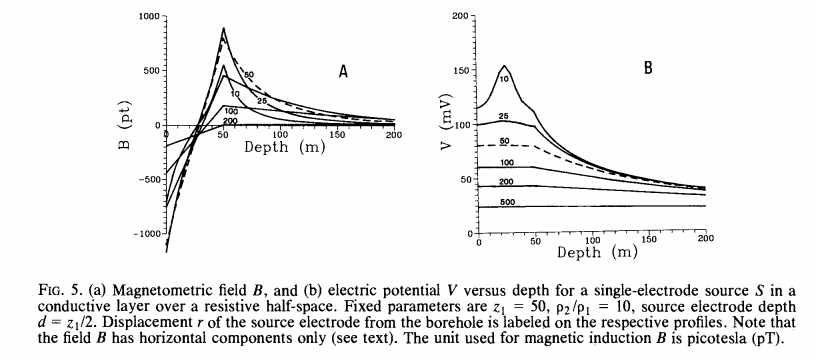

In [ ]:
rhos = [10,100]
depths = [50] # Assume bottom halfspace goes to infinity
src = 25

def down_solve_alpha(lst_rho, lst_z, source_depth):
    
    pass